| **Chapter**                   | 9:  Agent-based models             |
| ----------------------------- |------------------------------------|
| **Computational Note**        | 9.x: Q infector                    |
| **Package prerequisites**     | [Mesa](http://mesa.readthedocs.io) |

# Q infector

 In $q$ infection, an infectious patient will identify $q$ of its neighbours (or all of them, if there are fewer than $q$). It will then make contact only with the identified subset of neighbours. This reflects the fact of life that we are, regardless of the size of our social circle, limited by certain bounds, such as time. We have a limited bandwidth to interact with others, especially compared to our 'neighbourhood': our social network might involve hundreds of people, but we rarely see more than a handful of them per day.

In [1]:
import numpy as np
import pandas as pd
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector
from mesa import batchrunner
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import networkx as nx
import enum
import random


COLORS = {"S": "#2f4b7c",
          "E": "#ffa600",
          "I": "#f95d6a",
          "R": "#a05195",
          "D": "#003f5c",
          "C": "#ff7c43",
          "X": "#665191",
          "Y": "#d45087"}

In [2]:
class State(enum.IntEnum):
    SUSCEPTIBLE = 0
    INFECTED = 1
    RECOVERED = 2
    DECEASED = 3

In [3]:
class Person(Agent):
    def __init__(self, uid, model):
        super().__init__(uid, model)
        
        # Naive start
        self.state = State.SUSCEPTIBLE
        
    def contact_event(self):
        neighbourhood = self.model.grid.get_neighbors(self.pos, include_center=False)
        susceptible_neighbourhood = [agent for agent in self.model.grid.get_cell_list_contents(neighbourhood) 
                                                                            if agent.state is State.SUSCEPTIBLE]

        q_choice = random.sample(susceptible_neighbourhood, min(self.model.q, len(susceptible_neighbourhood)))

        for neighbour in q_choice:
            if np.random.rand() < self.model.beta:
                neighbour.state = State.INFECTED

    def status_update(self):        
        if self.state == State.INFECTED:
            if np.random.rand() < 1/self.model.recovery_period:
                if np.random.rand() < self.model.CFR:
                    self.state = State.DECEASED
                else:
                    self.state = State.RECOVERED

        if np.random.rand() < self.model.base_mortality_rate:
            self.state = State.DECEASED


    def step(self):
        self.status_update()

        if self.state is State.INFECTED:
            self.contact_event()
    

In [4]:
class NetworkInfectiousDiseaseModel(Model):

    def __init__(self, 
                 nodes=5000, 
                 mean_degree=12,
                 recovery_period=14,
                 beta=0.04,
                 CFR=0.05,
                 base_mortality_rate=0.000125,
                 I0=0.005,
                 q=4):
                     
        self.N_agents = nodes
        self.recovery_period = recovery_period
        self.beta = beta
        self.CFR = CFR
        self.base_mortality_rate = base_mortality_rate
        self.q = q

        self.graph = nx.erdos_renyi_graph(n=self.N_agents, p=mean_degree/self.N_agents)
        self.grid = NetworkGrid(self.graph)

        self.schedule = RandomActivation(self)
        self.running = True

        for idx, node in enumerate(self.graph.nodes()):
            agent = Person(uid=idx + 1, model=self)
            self.schedule.add(agent)
            self.grid.place_agent(agent, node)

            if np.random.rand() < I0:
                agent.state = State.INFECTED

        self.datacollector = DataCollector({"Infectious": lambda m: m.number_infectious()})

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

    def number_infectious(self):
        return np.sum([1 for i in self.schedule.agents if i.state is State.INFECTED])

In [5]:
br = batchrunner.FixedBatchRunner(NetworkInfectiousDiseaseModel,
                                  fixed_parameters={"nodes": 2000},
                                  parameters_list=[{"q": 3}, {"q": 5}, {"q": 7}],
                                  iterations=15,
                                  max_steps=200,
                                  model_reporters={"vals": lambda m: m.datacollector},
                                  display_progress=True)

In [6]:
br.run_all()

45it [01:08,  1.51s/it]


In [7]:
by_q_values = {}

for i in range(len(br.get_model_vars_dataframe().q)):
    if br.get_model_vars_dataframe().q[i] not in by_q_values.keys():
        by_q_values[br.get_model_vars_dataframe().q[i]] = []
    
    by_q_values[br.get_model_vars_dataframe().q[i]].append(
        br.get_model_vars_dataframe().vals[i].get_model_vars_dataframe()["Infectious"]
    )

In [8]:
means, sds = {}, {}

for i in br.get_model_vars_dataframe().q.unique():
    mu = pd.concat([*(by_q_values[i])], axis=1).mean(axis=1)
    sigma = pd.concat([*(by_q_values[i])], axis=1).std(axis=1)

    means[i] = mu
    sds[i] = sigma

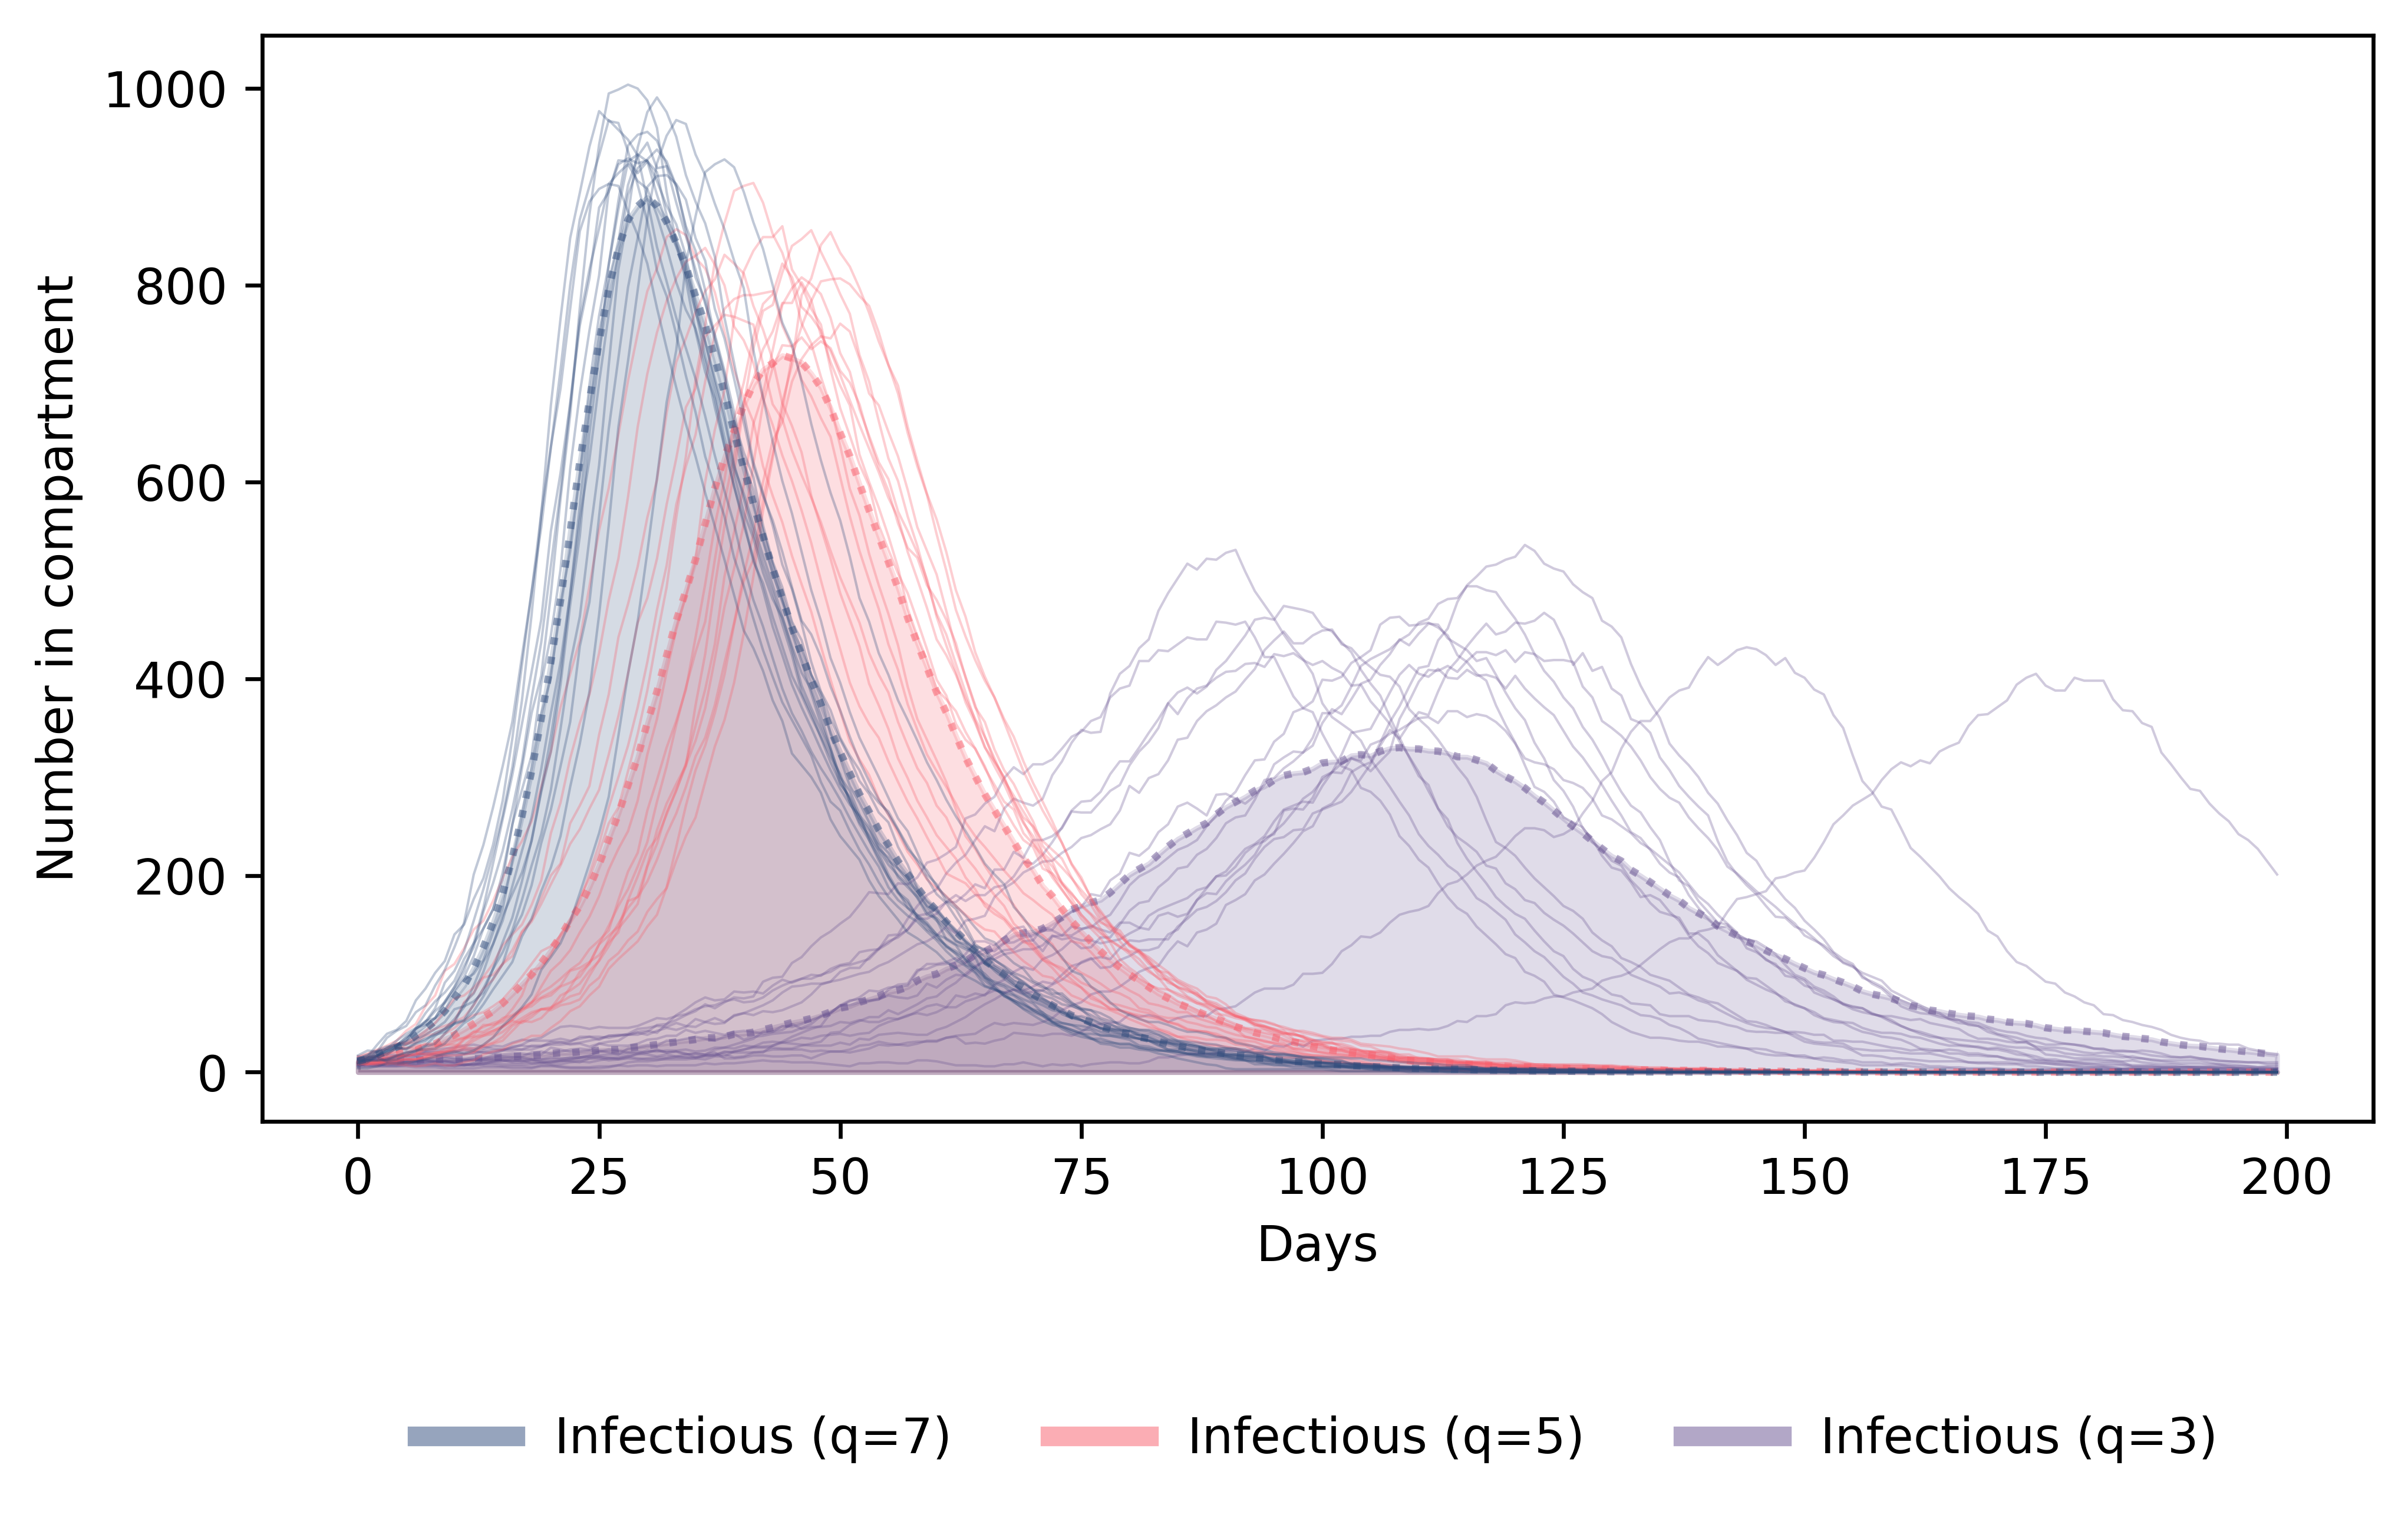

In [9]:
fig = plt.figure(facecolor="w", figsize=(8, 6), dpi=600)
ax = fig.add_subplot(111, axisbelow=True)

colour_cycle = ["X", "I", "S"]

logged_qs = []
linestyle_idx = 0

for idx, q in enumerate(by_q_values.keys()):
    for ts in by_q_values[q]:
        ax.plot(ts, color=COLORS[colour_cycle[idx]], alpha=0.3, lw=0.5, label="")
        logged_qs.append(q)
    linestyle_idx += 1

    ax.plot(means[q], color=COLORS[colour_cycle[idx]], lw=1.5, alpha=0.5, linestyle=":")
    ax.fill_between(ts.index, means[q], 0, color=COLORS[colour_cycle[idx]], alpha=0.2)

legend_lines = [Line2D([0], [0], color=COLORS["S"], lw=4, alpha=0.5),
                Line2D([0], [0], color=COLORS["I"], lw=4, alpha=0.5),
                Line2D([0], [0], color=COLORS["X"], lw=4, alpha=0.5)]

ax.legend(legend_lines, ["Infectious (q=7)", "Infectious (q=5)", "Infectious (q=3)"], title="", bbox_to_anchor=(0.5, -0.355), loc="lower center", ncol=3, frameon=False)


ax.set_xlabel("Days")
ax.set_ylabel("Number in compartment")

fig.tight_layout(pad=5.0)
plt.savefig("Q_infector.pdf")